In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '50 percent More sell CNN Images Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                   

In [6]:
r_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                   

## Train Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


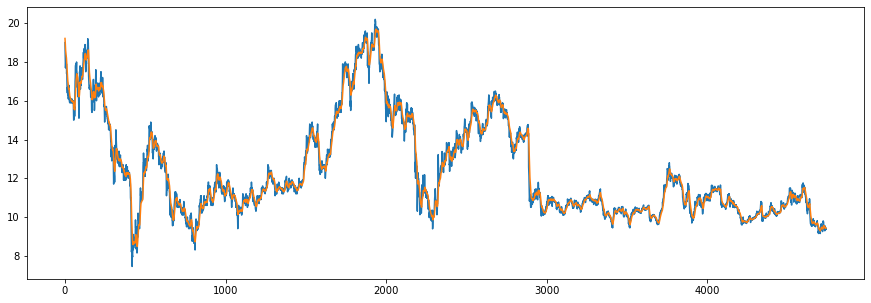

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


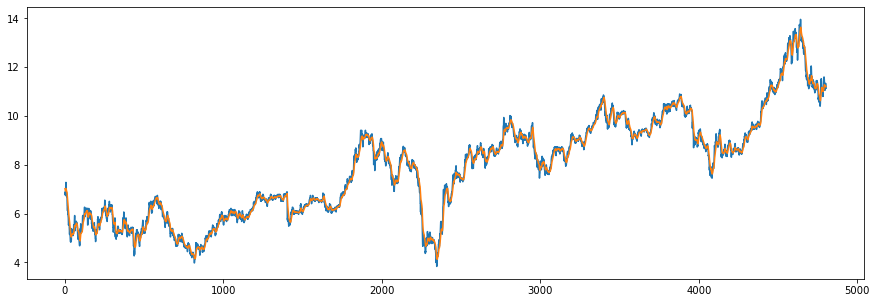

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     3.189194  3.249583 -69.696967   61394527.0     2.0
2000-01-25     3.205140  3.242745 -79.136806   75032521.0     2.0
2000-01-26     3.402870  3.267380 -34.532549  127274101.0     2.0
2000-01-27     3.284870  3.270071 -62.500055   91746305.0     2.0
2000-01-28     3.252978  3.267441 -69.852957   65314909.0     2.0


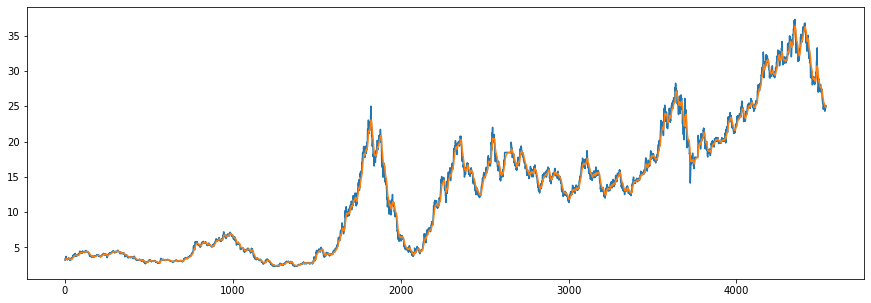

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


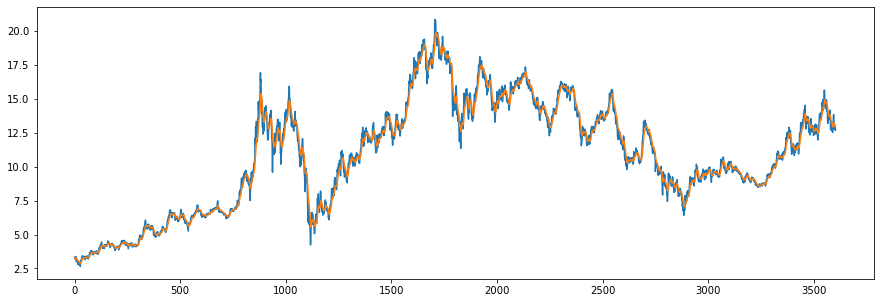

            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2006-11-17     3.953848  3.652647 -15.942120  1.897904e+10     2.0
2006-11-20     3.934226  3.695967 -18.840636  1.837444e+10     2.0
2006-11-21     3.934226  3.732622 -19.403036  1.837444e+10     2.0
2006-11-22     3.934226  3.763638 -19.697025  1.837444e+10     0.0
2006-11-23     4.051959  3.807995  -1.562480  1.907354e+10     2.0


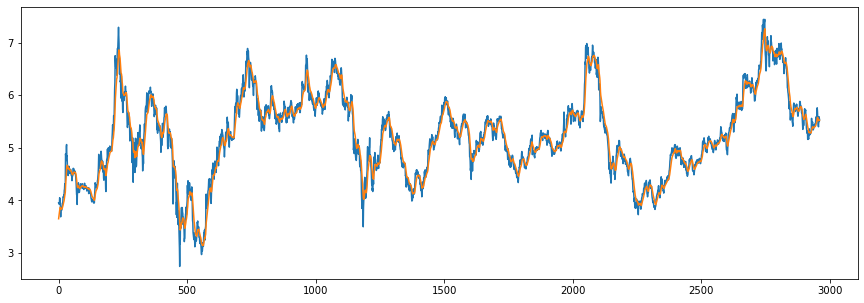

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      21.5000  24.211693 -82.142857  -6805500.0     2.0
2000-01-24      20.2500  23.602201 -92.465753  -8986800.0     1.0
2000-01-25      20.1875  23.076863 -92.307692 -11383100.0     2.0
2000-01-26      20.8750  22.738115 -82.786885  -9392500.0     2.0
2000-01-27      22.8750  22.759174 -56.557377  -6811000.0     2.0


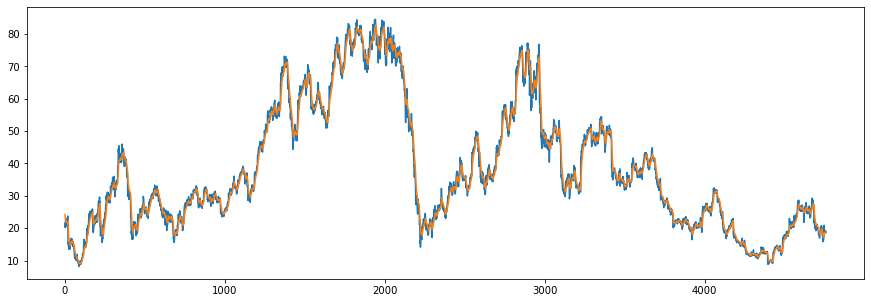

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


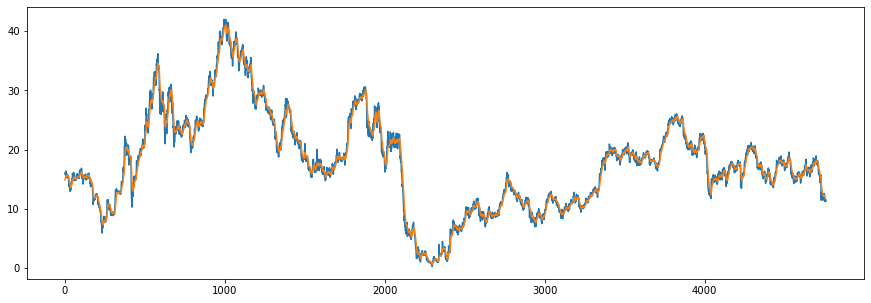

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


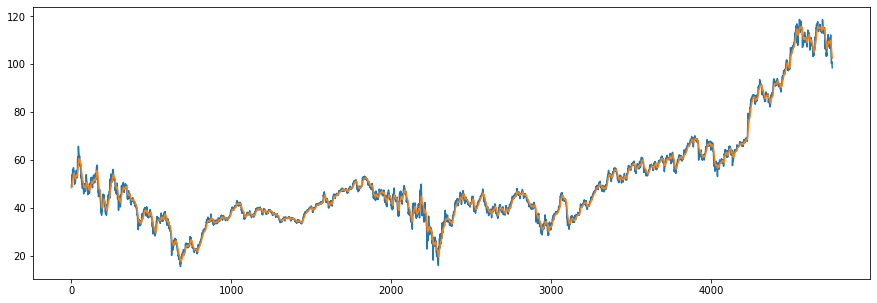

            previous_1d     EMA_12    willr_14     OBV_7  labels
Date                                                            
2000-01-21      13.7500  14.817184  -97.297297 -827200.0     2.0
2000-01-24      14.0625  14.701079  -77.500000 -518900.0     2.0
2000-01-25      13.6875  14.545144  -92.500000 -906100.0     2.0
2000-01-26      13.7500  14.422814  -90.000000 -652700.0     2.0
2000-01-27      13.5000  14.280843 -100.000000 -848400.0     2.0


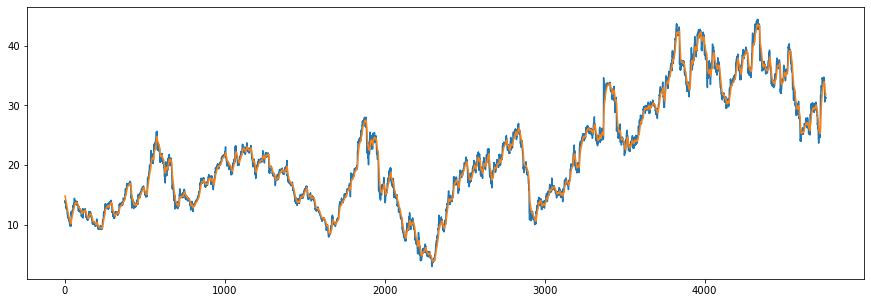

            previous_1d     EMA_12  willr_14      OBV_7  labels
Date                                                           
2010-12-21    18.799999  18.175961      -0.0  1579000.0     0.0
2010-12-22    19.000000  18.302736      -0.0  1699000.0     2.0
2010-12-23    19.000000  18.410008      -0.0  1699000.0     2.0
2010-12-27    19.000000  18.500776      -0.0  1699000.0     2.0
2010-12-28    19.000000  18.577580      -0.0  1699000.0     2.0


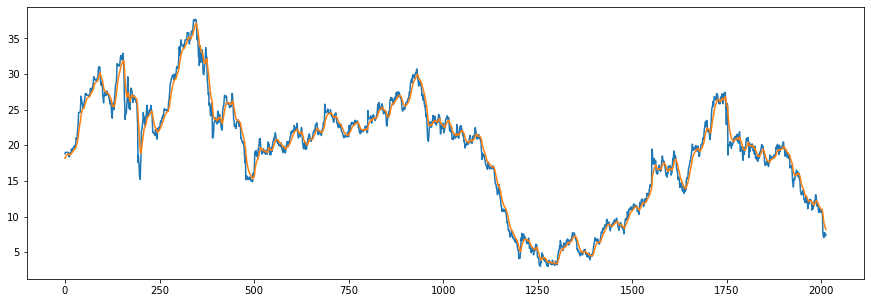

In [10]:
sequential_data = []
labels = []

train_sets = ['C6L.SI','O39.SI','600104.SS','0883.HK','1398.HK','ANF','AXL','JPM','CTB','TROX']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    data_15_price = []
    data_15_willr = []
    data_15_ema = []
    data_15_obv = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
            data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
            data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
            data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
            price_data.append(data_15_price_arr)
            willr_data.append(data_15_willr_arr)
            ema_data.append(data_15_ema_arr)
            obv_data.append(data_15_obv_arr)
            labels.append(i[-1])
            data_15_price = data_15_price[1:]
            data_15_willr = data_15_willr[1:]
            data_15_obv = data_15_obv[1:]
            data_15_ema = data_15_ema[1:]

        else:
            data_15_price.append([i[0]])
            data_15_ema.append([i[1]])
            data_15_willr.append([i[2]])
            data_15_obv.append([i[3]])
            count += 1
            
    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
        
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()

In [11]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(41550, 64, 64, 1)

In [12]:
from collections import Counter

Counter(y)

Counter({2.0: 37853, 0.0: 1852, 1.0: 1845})

In [13]:
X = sequential_data
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:1845]
class_1 = class_1[0:923]
class_2 = class_2[0:923]

class_0_labels = class_0_labels[0:1845]
class_1_labels = class_1_labels[0:923]
class_2_labels = class_2_labels[0:923]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

print(X.shape)

Counter(y)

(3691, 64, 64, 1)


Counter({0.0: 1845, 1.0: 923, 2.0: 923})

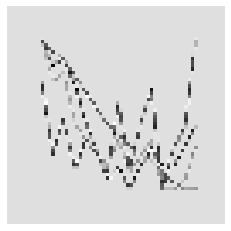

In [14]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [15]:
X = X/255

In [16]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [17]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [18]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 1 ... 0 2 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}



RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/24 [>.............................] - ETA: 0s - loss: 0.4724 - accuracy: 0.3047 - mse: 6.0556 - weighted_accuracy: 0.3436 - weighted_mse: 6.0730WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
24/24 [==============================] - 1s 36ms/step - loss: 0.2398 - accuracy: 0.3320 - mse: 1.6527 - weighted_accuracy: 0.3403 - weighted_mse: 1.6569 - val_loss: 0.1933 - val_accuracy: 0.4980 - val_mse: 0.9590 - val_weighted_accuracy: 0.4980 - val_weighted_mse: 0.9590
Epoch 2/20
24/24 [==============================] - 0s 15ms/step - loss: 0.2052 - accuracy: 0.3720 - mse: 1.1988 - weighted_accuracy: 0.3523 - weighted_mse: 1.2037 - val_loss: 0.1949

7/7 [==============================] - 0s 10ms/step - loss: 0.1978 - accuracy: 0.2279 - mse: 0.9769 - weighted_accuracy: 0.2279 - weighted_mse: 0.9769
Test loss: 0.19778789579868317
Test accuracy: 0.2279069721698761


number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 54
actual holds but predicted sell: 106
actual predicted holds: 38
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 6.956521739130435%
Percentage holds correct: 88.37209302325581%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 42.10526315789474%
Percentage high sells correct: 53.50877192982456%
Percentage mid holds correct: 83.72093023255815%


Capital: 100
Share price: $0.9763550825449694
Shares owned at the moment: 102
Cash capital at the moment: $0.13791397975924724


Pric

Capital at the end of test period if Buy and Hold: $44.097971344241664
profit gained: -55.90202865575834%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.146789      9.677419       4.545455      83.333333   
1       0.206422      3.389831       6.722689      87.500000   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         53.225806           44.274809               75.0     124.867878   
1         49.152542           48.305085               82.5     -97.081629   

   buy_n_hold profit  
0         -64.154600  
1         -55.902029  
Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.1965 - accuracy: 0.2279 - mse: 1.0004 - weighted_accuracy: 0.2279 - weighted_mse: 1.0004
Test loss: 0.19646982848644257
Test accuracy: 0.2279069721698761


number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 4
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predi

   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.146789      9.677419       4.545455      83.333333   
1       0.206422      3.389831       6.722689      87.500000   
2       0.222749      3.389831       5.504587      90.697674   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         53.225806           44.274809          75.000000     124.867878   
1         49.152542           48.305085          82.500000     -97.081629   
2         52.542373           50.925926          76.744186      23.176968   

   buy_n_hold profit  
0         -64.154600  
1         -55.902029  
2         -54.689601  
Recession Test


7/7 [==============================] - 0s 10ms/step - loss: 0.1977 - accuracy: 0.2441 - mse: 0.9949 - weighted_accuracy: 0.2441 - weighted_mse: 0.9949
Test loss: 0.1976841688156128
Test accuracy: 0.24413146078586578


number of predictions: 213
actual predicted buys: 2
actual buys but predicted sell: 3
actual buys but predi



Price increase from previously bought: 3.625540918689052%
Share price: $0.9139493058221533
Shares owned at the moment: 0
Cash capital at the moment: $2834.455347148641




Capital at the end of test period: $2834.455347148641
profit gained: 2734.455347148641%


Capital at the end of test period if Buy and Hold: $1676.1791664809543
profit gained: 1576.1791664809543%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.146789      9.677419       4.545455      83.333333   
1       0.206422      3.389831       6.722689      87.500000   
2       0.222749      3.389831       5.504587      90.697674   
3       0.128440     10.000000       4.285714      88.888889   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         53.225806           44.274809          75.000000     124.867878   
1         49.152542           48.305085          82.500000     -97.081629   
2         52.542373           50.925926          76.744186      23.176968   
3


Price increase from previously bought: -33.52882684915147%
Share price: $0.12813186381321262
Shares owned at the moment: 0
Cash capital at the moment: $9.877082849145607


Share price: $0.13912086424551007
Shares owned at the moment: 70
Cash capital at the moment: $0.11184158559264112


Price increase from previously bought: 29.26536373557287%
Share price: $0.18032963769982846
Shares owned at the moment: 0
Cash capital at the moment: $12.700202769323417


Share price: $0.39278382072320317
Shares owned at the moment: 32
Cash capital at the moment: $0.09655552995727312


Price increase from previously bought: 10.420955531249%
Share price: $0.43490836604674943
Shares owned at the moment: 0
Cash capital at the moment: $13.97535130724114


Share price: $0.37172159172783625
Shares owned at the moment: 37
Cash capital at the moment: $0.18382974135289132


Price increase from previously bought: -1.748326277567691%
Share price: $0.3662270478452814
Shares owned at the moment: 0
Cash capital at 

4         -32.509770  



RUNNING EPOCHS 20 - 40



Epoch 1/20
24/24 [==============================] - 1s 34ms/step - loss: 0.1913 - accuracy: 0.4671 - mse: 1.2167 - weighted_accuracy: 0.4440 - weighted_mse: 1.2231 - val_loss: 0.1812 - val_accuracy: 0.6076 - val_mse: 0.9651 - val_weighted_accuracy: 0.6076 - val_weighted_mse: 0.9651
Epoch 2/20
24/24 [==============================] - 0s 18ms/step - loss: 0.1917 - accuracy: 0.4590 - mse: 1.2179 - weighted_accuracy: 0.4334 - weighted_mse: 1.2217 - val_loss: 0.1793 - val_accuracy: 0.5954 - val_mse: 0.9889 - val_weighted_accuracy: 0.5954 - val_weighted_mse: 0.9889
Epoch 3/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1915 - accuracy: 0.4688 - mse: 1.1981 - weighted_accuracy: 0.4363 - weighted_mse: 1.2095 - val_loss: 0.1802 - val_accuracy: 0.6035 - val_mse: 0.8967 - val_weighted_accuracy: 0.6035 - val_weighted_mse: 0.8967
Epoch 4/20
24/24 [==============================] - 0s 14ms/step - loss: 0.1920 - accuracy: 0.4560 

0           -64.1546  
Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2033 - accuracy: 0.0884 - mse: 1.1192 - weighted_accuracy: 0.0884 - weighted_mse: 1.1192
Test loss: 0.2033010721206665
Test accuracy: 0.08837209641933441


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 100
actual holds but predicted sell: 94
actual predicted holds: 4
Percentage buys correct: 6.481481481481482%
Percentage sells correct: 7.766990291262136%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 46.2962962962963%
Percentage high sells correct: 53.92156862745098%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $1.0025233714829802
Shares owned at the moment: 99
Cash capital at the moment: $0.4772492352987


Price increase from previously bought: 1.4212960320358015%
Share price: $0.73392593169001
Shares owned at the moment: 0
Cash capital at the moment: $165.05230968696313


Share price: $0.8198157068393652
Shares owned at the moment: 200
Cash capital at the moment: $0.6382696803284205


Price increase from previously bought: 0.47205410422999083%
Share price: $0.8259508161520819
Shares owned at the moment: 0
Cash capital at the moment: $165.37415996186115


Share price: $0.6603063751660889
Shares owned at the moment: 249
Cash capital at the moment: $0.5057277551100299


Price increase from previously bought: -32.7038418290306%
Share price: $0.4455828149070389
Shares owned at the moment: 0
Cash capital at the moment: $111.1507358344551


Share price: $0.40263763479424886
Shares owned at the moment: 275
Cash capital at the moment: $0.12089155472351365


Price increase from previously bought: -32.18409135332296%
Share price: $0.27380326460832927
Shares owned at the moment: 0
Cash capital at 

0883.HK


Non-Recession Test


7/7 [==============================] - 0s 11ms/step - loss: 0.2084 - accuracy: 0.0616 - mse: 1.1714 - weighted_accuracy: 0.0616 - weighted_mse: 1.1714
Test loss: 0.2084396630525589
Test accuracy: 0.061611372977495193


number of predictions: 211
actual predicted buys: 3
actual buys but predicted sell: 5
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 98
actual holds but predicted sell: 92
actual predicted holds: 4
Percentage buys correct: 2.8846153846153846%
Percentage sells correct: 5.825242718446602%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 49.03846153846154%
Percentage high sells correct: 50.98039215686274%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722

7/7 [==============================] - 0s 6ms/step - loss: 0.2139 - accuracy: 0.0780 - mse: 1.2187 - weighted_accuracy: 0.0780 - weighted_mse: 1.2187
Test loss: 0.21394959092140198
Test accuracy: 0.07798165082931519


number of predictions: 218
actual predicted buys: 9
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 68
actual holds but predicted sell: 131
actual predicted holds: 2
Percentage buys correct: 11.688311688311689%
Percentage sells correct: 4.316546762589928%
Percentage holds correct: 100.0%
actual buys: 11
actual sells: 6
actual holds: 201


Percentage low buys correct: 50.64935064935065%
Percentage high sells correct: 47.10144927536232%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.05968146056768497
Shares owned at the moment: 1670
Cash capital at the moment: $0.05787374430900627


Price increase from previo

7/7 [==============================] - 0s 5ms/step - loss: 0.2067 - accuracy: 0.0688 - mse: 1.1644 - weighted_accuracy: 0.0688 - weighted_mse: 1.1644
Test loss: 0.2067374885082245
Test accuracy: 0.06880734115839005


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 3
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 98
actual holds but predicted sell: 99
actual predicted holds: 5
Percentage buys correct: 2.9411764705882355%
Percentage sells correct: 6.422018348623853%
Percentage holds correct: 71.42857142857143%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 41.1764705882353%
Percentage high sells correct: 48.148148148148145%
Percentage mid holds correct: 71.42857142857143%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price i




RUNNING EPOCHS 40 - 60



Epoch 1/20
24/24 [==============================] - 1s 22ms/step - loss: 0.1810 - accuracy: 0.5434 - mse: 1.2822 - weighted_accuracy: 0.5099 - weighted_mse: 1.2839 - val_loss: 0.1638 - val_accuracy: 0.6265 - val_mse: 1.1345 - val_weighted_accuracy: 0.6265 - val_weighted_mse: 1.1345
Epoch 2/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1810 - accuracy: 0.5346 - mse: 1.2965 - weighted_accuracy: 0.5038 - weighted_mse: 1.2905 - val_loss: 0.1677 - val_accuracy: 0.6143 - val_mse: 1.0219 - val_weighted_accuracy: 0.6143 - val_weighted_mse: 1.0219
Epoch 3/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1800 - accuracy: 0.5461 - mse: 1.3048 - weighted_accuracy: 0.5165 - weighted_mse: 1.3065 - val_loss: 0.1666 - val_accuracy: 0.6252 - val_mse: 0.9985 - val_weighted_accuracy: 0.6252 - val_weighted_mse: 0.9985
Epoch 4/20
24/24 [==============================] - 0s 14ms/step - loss: 0.1781 - accuracy: 0.5583 - mse: 1.2666 - weighte

0           -64.1546  
Recession Test


7/7 [==============================] - 0s 6ms/step - loss: 0.1930 - accuracy: 0.1860 - mse: 1.1592 - weighted_accuracy: 0.1860 - weighted_mse: 1.1592
Test loss: 0.1930328905582428
Test accuracy: 0.1860465109348297


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 97
actual holds but predicted sell: 74
actual predicted holds: 27
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 93.10344827586206%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.61904761904762%
Percentage high sells correct: 57.5%
Percentage mid holds correct: 89.65517241379311%


Capital: 100
Share price: $1.0025233714829802
Shares owned at the moment: 99
Cash capital at the moment: $0.47

Share price: $0.6603063751660889
Shares owned at the moment: 202
Cash capital at the moment: $0.4331226915867319


Price increase from previously bought: -32.7038418290306%
Share price: $0.4455828149070389
Shares owned at the moment: 0
Cash capital at the moment: $90.19333004912772


Share price: $0.3658281490704012
Shares owned at the moment: 245
Cash capital at the moment: $0.3189568114432433


Price increase from previously bought: -87.2396061422165%
Share price: $0.04680948572384857
Shares owned at the moment: 0
Cash capital at the moment: $11.7557429227797


Share price: $0.08975466583663859
Shares owned at the moment: 130
Cash capital at the moment: $0.05554907098008499


Price increase from previously bought: 61.07388060082908%
Share price: $0.14496889442240968
Shares owned at the moment: 0
Cash capital at the moment: $18.849678966137333


Share price: $0.5498773329183202
Shares owned at the moment: 34
Cash capital at the moment: $0.102436116286583


Price increase from previous

1         -24.562920  


0883.HK


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2037 - accuracy: 0.1517 - mse: 1.2395 - weighted_accuracy: 0.1517 - weighted_mse: 1.2395
Test loss: 0.20371289551258087
Test accuracy: 0.1516587734222412


number of predictions: 211
actual predicted buys: 4
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 87
actual holds but predicted sell: 85
actual predicted holds: 22
Percentage buys correct: 4.3478260869565215%
Percentage sells correct: 6.382978723404255%
Percentage holds correct: 88.0%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 54.34782608695652%
Percentage high sells correct: 53.763440860215056%
Percentage mid holds correct: 76.0%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment

Share price: $0.4695959583796625
Shares owned at the moment: 0
Cash capital at the moment: $27.18203893373187


Share price: $0.4190908762508847
Shares owned at the moment: 64
Cash capital at the moment: $0.2864628594550922


Price increase from previously bought: 3.7317854065720413%
Share price: $0.43592595714422067
Shares owned at the moment: 0
Cash capital at the moment: $28.109001148227833


Share price: $0.3786868747683543
Shares owned at the moment: 74
Cash capital at the moment: $0.009109636354256878


Price increase from previously bought: 26.326356071968625%
Share price: $0.4796968784746798
Shares owned at the moment: 0
Cash capital at the moment: $35.409060328710964


Share price: $0.4275084166975527
Shares owned at the moment: 82
Cash capital at the moment: $0.2569670115463438


Price increase from previously bought: -14.411930705255404%
Share price: $0.3669024144737578
Shares owned at the moment: 0
Cash capital at the moment: $30.26022850393065


Share price: $0.41740733605

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.1959 - accuracy: 0.1918 - mse: 1.1892 - weighted_accuracy: 0.1918 - weighted_mse: 1.1892
Test loss: 0.19593185186386108
Test accuracy: 0.19178082048892975


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 73
actual holds but predicted sell: 101
actual predicted holds: 23
Percentage buys correct: 9.75609756097561%
Percentage sells correct: 9.734513274336283%
Percentage holds correct: 95.83333333333333%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 46.34146341463415%
Percentage high sells correct: 49.557522123893804%
Percentage mid holds correct: 91.30434782608695%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at

7/7 [==============================] - 0s 5ms/step - loss: 0.2010 - accuracy: 0.2100 - mse: 1.2264 - weighted_accuracy: 0.2100 - weighted_mse: 1.2264
Test loss: 0.20102038979530334
Test accuracy: 0.21004566550254822


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 67
actual holds but predicted sell: 101
actual predicted holds: 29
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 90.625%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 52.0%
Percentage high sells correct: 56.75675675675676%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increase from previously bought:

Epoch 7/20
24/24 [==============================] - 0s 13ms/step - loss: 0.1686 - accuracy: 0.6131 - mse: 1.3613 - weighted_accuracy: 0.5802 - weighted_mse: 1.3600 - val_loss: 0.1565 - val_accuracy: 0.6360 - val_mse: 1.1351 - val_weighted_accuracy: 0.6360 - val_weighted_mse: 1.1351
Epoch 8/20
24/24 [==============================] - 0s 13ms/step - loss: 0.1679 - accuracy: 0.6081 - mse: 1.3803 - weighted_accuracy: 0.5797 - weighted_mse: 1.3752 - val_loss: 0.1590 - val_accuracy: 0.6292 - val_mse: 1.0646 - val_weighted_accuracy: 0.6292 - val_weighted_mse: 1.0646
Epoch 9/20
24/24 [==============================] - 0s 13ms/step - loss: 0.1680 - accuracy: 0.6192 - mse: 1.3463 - weighted_accuracy: 0.5869 - weighted_mse: 1.3391 - val_loss: 0.1551 - val_accuracy: 0.6414 - val_mse: 1.1595 - val_weighted_accuracy: 0.6414 - val_weighted_mse: 1.1595
Epoch 10/20
24/24 [==============================] - 0s 13ms/step - loss: 0.1670 - accuracy: 0.6114 - mse: 1.3864 - weighted_accuracy: 0.5752 - weighte

7/7 [==============================] - 0s 13ms/step - loss: 0.1970 - accuracy: 0.2465 - mse: 1.2915 - weighted_accuracy: 0.2465 - weighted_mse: 1.2915
Test loss: 0.1969597190618515
Test accuracy: 0.24651162326335907


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 85
actual holds but predicted sell: 74
actual predicted holds: 39
Percentage buys correct: 7.526881720430108%
Percentage sells correct: 8.536585365853659%
Percentage holds correct: 97.5%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 46.236559139784944%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 95.0%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from previously 

Price increase from previously bought: 6.429418619588034%
Share price: $0.29220859254647835
Shares owned at the moment: 0
Cash capital at the moment: $11.000857044960155




Capital at the end of test period: $11.000857044960155
profit gained: -88.99914295503984%


Capital at the end of test period if Buy and Hold: $44.097971344241664
profit gained: -55.90202865575834%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.206422     10.526316       7.964602      96.551724   
1       0.188073      6.849315       7.079646      87.500000   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         53.947368           46.017699          96.428571     190.433405   
1         58.904110           55.357143          84.375000     -88.999143   

   buy_n_hold profit  
0         -64.154600  
1         -55.902029  
Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2022 - accuracy: 0.2140 - mse: 1.3480 - weighted_accurac

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2045 - accuracy: 0.2394 - mse: 1.3447 - weighted_accuracy: 0.2394 - weighted_mse: 1.3447
Test loss: 0.20448455214500427
Test accuracy: 0.23943662643432617


number of predictions: 213
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 71
actual holds but predicted sell: 84
actual predicted holds: 38
Percentage buys correct: 7.594936708860759%
Percentage sells correct: 7.446808510638298%
Percentage holds correct: 95.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 45.56962025316456%
Percentage high sells correct: 52.68817204301075%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.9965319995058233
Shares owned at the moment: 100
Cash capital at the moment: $0.0727537495

7/7 [==============================] - 0s 5ms/step - loss: 0.1998 - accuracy: 0.2557 - mse: 1.3426 - weighted_accuracy: 0.2557 - weighted_mse: 1.3426
Test loss: 0.19978897273540497
Test accuracy: 0.2557077705860138


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 60
actual holds but predicted sell: 100
actual predicted holds: 37
Percentage buys correct: 11.594202898550725%
Percentage sells correct: 9.821428571428571%
Percentage holds correct: 97.36842105263158%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.27536231884058%
Percentage high sells correct: 49.107142857142854%
Percentage mid holds correct: 86.48648648648648%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Pric

Share price: $0.4687912265456817
Shares owned at the moment: 98
Cash capital at the moment: $0.1951192144412488


Price increase from previously bought: -85.40504015504862%
Share price: $0.06860804597199253
Shares owned at the moment: 0
Cash capital at the moment: $6.900217851307064


Share price: $0.09608054705273604
Shares owned at the moment: 71
Cash capital at the moment: $0.05973928375075843


Price increase from previously bought: -54.45235499206337%
Share price: $0.04388277316612021
Shares owned at the moment: 0
Cash capital at the moment: $3.166848067084608


Share price: $0.03747250108074362
Shares owned at the moment: 84
Cash capital at the moment: $0.010501828552492043


Price increase from previously bought: 219.0640993736341%
Share price: $0.11989009165578655
Shares owned at the moment: 0
Cash capital at the moment: $10.053574916466076


Share price: $0.19681318201468057
Shares owned at the moment: 50
Cash capital at the moment: $0.1858540032050282


Price increase from pr

Capital at the end of test period: $2264.208086279997
profit gained: 2164.208086279997%


Capital at the end of test period if Buy and Hold: $67.49022981476901
profit gained: -32.50977018523099%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.246512      7.526882       8.536585      97.500000   
1       0.213953      7.317073       9.090909      91.176471   
2       0.239437      7.594937       7.446809      95.000000   
3       0.255708     11.594203       9.821429      97.368421   
4       0.219178      7.692308       7.894737      85.000000   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         46.236559           55.555556          95.000000     -61.253202   
1         53.658537           55.102041          88.235294     -21.029862   
2         45.569620           52.688172          85.000000     -87.548274   
3         49.275362           49.107143          86.486486      22.962357   
4         53.125000           56.14

Shares owned at the moment: 248
Cash capital at the moment: $0.09220797318518237


Price increase from previously bought: -34.343788758131076%
Share price: $0.0905368483171156
Shares owned at the moment: 0
Cash capital at the moment: $22.48360022527758


Share price: $0.01
Shares owned at the moment: 2242
Cash capital at the moment: $0.0019452252775771228


Price increase from previously bought: 1070.6054791605225%
Share price: $0.1173824644228214
Shares owned at the moment: 0
Cash capital at the moment: $262.4497088768442


Share price: $0.3724161374520112
Shares owned at the moment: 702
Cash capital at the moment: $0.2946310321812575


Price increase from previously bought: -23.637663377249773%
Share price: $0.285167725095975
Shares owned at the moment: 0
Cash capital at the moment: $199.9318577562579


Share price: $0.3589936494241448
Shares owned at the moment: 555
Cash capital at the moment: $0.1424682684239258


Price increase from previously bought: -5.867512890592607%
Share pri


Share price: $0.2137383499098866
Shares owned at the moment: 74
Cash capital at the moment: $0.04826551243941424


Price increase from previously bought: 1.4699718558755626%
Share price: $0.2174766641683964
Shares owned at the moment: 0
Cash capital at the moment: $16.097282159742477


Share price: $0.21186914821641079
Shares owned at the moment: 75
Cash capital at the moment: $0.16339803169203293




Capital at the end of test period: $16.569091220248016
profit gained: -83.43090877975199%


Capital at the end of test period if Buy and Hold: $21.761644528562254
profit gained: -78.23835547143774%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.204651      6.603774           10.0          100.0   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         46.226415           56.962025          96.551724     -83.430909   

   buy_n_hold profit  
0         -78.238355  


O39.SI


Non-Recession Test


7/7 [=============================

1         -24.562920  


0883.HK


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2207 - accuracy: 0.1422 - mse: 1.5096 - weighted_accuracy: 0.1422 - weighted_mse: 1.5096
Test loss: 0.2207290679216385
Test accuracy: 0.14218010008335114


number of predictions: 211
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 89
actual holds but predicted sell: 86
actual predicted holds: 19
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 6.382978723404255%
Percentage holds correct: 86.36363636363636%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 55.913978494623656%
Percentage mid holds correct: 77.27272727272727%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147


Price increase from previously bought: -21.591754741474045%
Share price: $0.3281817926395769
Shares owned at the moment: 0
Cash capital at the moment: $23.970299248452026


Share price: $0.2642087100166224
Shares owned at the moment: 90
Cash capital at the moment: $0.1261236912268977


Price increase from previously bought: -16.795639633940972%
Share price: $0.22043770841054844
Shares owned at the moment: 0
Cash capital at the moment: $19.910959115344646


Share price: $0.17835016672843862
Shares owned at the moment: 111
Cash capital at the moment: $0.05964922009410145


Price increase from previously bought: -13.453018961870168%
Share price: $0.15478116586362956
Shares owned at the moment: 0
Cash capital at the moment: $17.19311168007711


Share price: $0.16993262628177042
Shares owned at the moment: 100
Cash capital at the moment: $0.15311757967257833


Price increase from previously bought: -9.165951025795804%
Share price: $0.15478116586362956
Shares owned at the moment: 0
Cash capi

7/7 [==============================] - 0s 6ms/step - loss: 0.2046 - accuracy: 0.2511 - mse: 1.4292 - weighted_accuracy: 0.2511 - weighted_mse: 1.4292
Test loss: 0.20456497371196747
Test accuracy: 0.2511415481567383


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 71
actual holds but predicted sell: 90
actual predicted holds: 36
Percentage buys correct: 10.0%
Percentage sells correct: 10.784313725490197%
Percentage holds correct: 97.29729729729729%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.5%
Percentage high sells correct: 51.96078431372549%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase from previously b

Share price: $0.3918681361867874
Shares owned at the moment: 122
Cash capital at the moment: $0.19572669538089826


Price increase from previously bought: -5.401300449450885%
Share price: $0.37172159172783625
Shares owned at the moment: 0
Cash capital at the moment: $45.42104829215223


Share price: $0.3506592753996569
Shares owned at the moment: 129
Cash capital at the moment: $0.06160538764845569


Price increase from previously bought: 4.15315124461213%
Share price: $0.3662270478452814
Shares owned at the moment: 0
Cash capital at the moment: $47.17497551446664


Share price: $0.32868127453506213
Shares owned at the moment: 143
Cash capital at the moment: $0.04429934474183739


Price increase from previously bought: 14.451800347681898%
Share price: $0.377216135610391
Shares owned at the moment: 0
Cash capital at the moment: $53.83786649169897




Capital at the end of test period: $53.83786649169897
profit gained: -46.16213350830103%


Capital at the end of test period if Buy and Ho




RUNNING EPOCHS 100 - 120



Epoch 1/20
24/24 [==============================] - 1s 23ms/step - loss: 0.1529 - accuracy: 0.6755 - mse: 1.4774 - weighted_accuracy: 0.6511 - weighted_mse: 1.4659 - val_loss: 0.1503 - val_accuracy: 0.6549 - val_mse: 1.2309 - val_weighted_accuracy: 0.6549 - val_weighted_mse: 1.2309
Epoch 2/20
24/24 [==============================] - 0s 21ms/step - loss: 0.1535 - accuracy: 0.6633 - mse: 1.4516 - weighted_accuracy: 0.6396 - weighted_mse: 1.4420 - val_loss: 0.1501 - val_accuracy: 0.6549 - val_mse: 1.2707 - val_weighted_accuracy: 0.6549 - val_weighted_mse: 1.2707
Epoch 3/20
24/24 [==============================] - 0s 15ms/step - loss: 0.1524 - accuracy: 0.6711 - mse: 1.4780 - weighted_accuracy: 0.6477 - weighted_mse: 1.4658 - val_loss: 0.1509 - val_accuracy: 0.6360 - val_mse: 1.3221 - val_weighted_accuracy: 0.6360 - val_weighted_mse: 1.3221
Epoch 4/20
24/24 [==============================] - 0s 14ms/step - loss: 0.1517 - accuracy: 0.6673 - mse: 1.4835 - weigh


Share price: $0.4596645498080483
Shares owned at the moment: 114
Cash capital at the moment: $0.16999888423877962


Price increase from previously bought: 2.6379464943552255%
Share price: $0.47308767788588857
Shares owned at the moment: 0
Cash capital at the moment: $53.95368117621285


Share price: $0.285167725095975
Shares owned at the moment: 188
Cash capital at the moment: $0.19471714429493403


Price increase from previously bought: -40.173968106713495%
Share price: $0.1710736966342321
Shares owned at the moment: 0
Cash capital at the moment: $32.26812701037067


Share price: $0.1173824644228214
Shares owned at the moment: 274
Cash capital at the moment: $0.016884071575013593


Price increase from previously bought: -23.081735218803846%
Share price: $0.0905368483171156
Shares owned at the moment: 0
Cash capital at the moment: $24.75576099525774


Share price: $0.01
Shares owned at the moment: 2468
Cash capital at the moment: $0.007890995257742617


Price increase from previously 

7/7 [==============================] - 0s 14ms/step - loss: 0.2293 - accuracy: 0.1606 - mse: 1.5964 - weighted_accuracy: 0.1606 - weighted_mse: 1.5964
Test loss: 0.22933650016784668
Test accuracy: 0.16055046021938324


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 77
actual holds but predicted sell: 102
actual predicted holds: 22
Percentage buys correct: 7.228915662650603%
Percentage sells correct: 6.422018348623853%
Percentage holds correct: 84.61538461538461%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 60.24096385542169%
Percentage high sells correct: 56.48148148148148%
Percentage mid holds correct: 80.76923076923077%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capital at the moment: $0.5476785749706323


Price

Share price: $0.22646355779520433
Shares owned at the moment: 0
Cash capital at the moment: $52.40425599041628


Share price: $0.2447560767294903
Shares owned at the moment: 213
Cash capital at the moment: $0.12784577509054884


Price increase from previously bought: -0.27424582398404285%
Share price: $0.2447560767294903
Shares owned at the moment: 0
Cash capital at the moment: $52.11752424652769


Share price: $0.2935365148933824
Shares owned at the moment: 177
Cash capital at the moment: $0.018682211774653013


Price increase from previously bought: 0.7615669541730652%
Share price: $0.2965853649672121
Shares owned at the moment: 0
Cash capital at the moment: $52.369928884573405


Share price: $0.2721951458852663
Shares owned at the moment: 191
Cash capital at the moment: $0.23768552011130595


Price increase from previously bought: 28.76777363470473%
Share price: $0.3514635032787641
Shares owned at the moment: 0
Cash capital at the moment: $67.18260844125808


Share price: $0.6990242

7/7 [==============================] - 0s 15ms/step - loss: 0.2201 - accuracy: 0.2207 - mse: 1.5460 - weighted_accuracy: 0.2207 - weighted_mse: 1.5460
Test loss: 0.22006604075431824
Test accuracy: 0.22065727412700653


number of predictions: 213
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 77
actual holds but predicted sell: 82
actual predicted holds: 34
Percentage buys correct: 7.0588235294117645%
Percentage sells correct: 7.608695652173913%
Percentage holds correct: 94.44444444444444%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 42.35294117647059%
Percentage high sells correct: 51.64835164835165%
Percentage mid holds correct: 80.55555555555556%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Pr

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.2097 - accuracy: 0.2968 - mse: 1.5139 - weighted_accuracy: 0.2968 - weighted_mse: 1.5139
Test loss: 0.20967569947242737
Test accuracy: 0.29680365324020386


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 61
actual holds but predicted sell: 89
actual predicted holds: 47
Percentage buys correct: 10.144927536231885%
Percentage sells correct: 10.891089108910892%
Percentage holds correct: 95.91836734693878%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 46.3768115942029%
Percentage high sells correct: 51.48514851485149%
Percentage mid holds correct: 81.25%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment:

Shares owned at the moment: 104
Cash capital at the moment: $0.1059016681439644


Price increase from previously bought: -85.40504015504862%
Share price: $0.06860804597199253
Shares owned at the moment: 0
Cash capital at the moment: $7.221516548083198


Share price: $0.09608054705273604
Shares owned at the moment: 74
Cash capital at the moment: $0.09200367485549865


Price increase from previously bought: -54.45235499206337%
Share price: $0.04388277316612021
Shares owned at the moment: 0
Cash capital at the moment: $3.3303987448090884


Share price: $0.03747250108074362
Shares owned at the moment: 88
Cash capital at the moment: $0.023750304442109904


Price increase from previously bought: 219.0640993736341%
Share price: $0.11989009165578655
Shares owned at the moment: 0
Cash capital at the moment: $10.545064967970626


Share price: $0.19681318201468057
Shares owned at the moment: 53
Cash capital at the moment: $0.08528079991391735


Price increase from previously bought: -15.122681991

4         -32.509770  



RUNNING EPOCHS 120 - 140



Epoch 1/20
24/24 [==============================] - 1s 25ms/step - loss: 0.1430 - accuracy: 0.7134 - mse: 1.5497 - weighted_accuracy: 0.6953 - weighted_mse: 1.5230 - val_loss: 0.1478 - val_accuracy: 0.6509 - val_mse: 1.4285 - val_weighted_accuracy: 0.6509 - val_weighted_mse: 1.4285
Epoch 2/20
24/24 [==============================] - 0s 18ms/step - loss: 0.1415 - accuracy: 0.7093 - mse: 1.5608 - weighted_accuracy: 0.6920 - weighted_mse: 1.5268 - val_loss: 0.1484 - val_accuracy: 0.6617 - val_mse: 1.3605 - val_weighted_accuracy: 0.6617 - val_weighted_mse: 1.3605
Epoch 3/20
24/24 [==============================] - 0s 14ms/step - loss: 0.1442 - accuracy: 0.6917 - mse: 1.5656 - weighted_accuracy: 0.6762 - weighted_mse: 1.5448 - val_loss: 0.1502 - val_accuracy: 0.6171 - val_mse: 1.4089 - val_weighted_accuracy: 0.6171 - val_weighted_mse: 1.4089
Epoch 4/20
24/24 [==============================] - 0s 14ms/step - loss: 0.1428 - accuracy: 0.703

Share price: $0.5938926303365772
Shares owned at the moment: 181
Cash capital at the moment: $0.33492253780734416


Price increase from previously bought: -48.73397605381011%
Share price: $0.305302417212735
Shares owned at the moment: 0
Cash capital at the moment: $55.442695775144735


Share price: $0.305302417212735
Shares owned at the moment: 181
Cash capital at the moment: $0.030993981472065002


Price increase from previously bought: -4.658854315410177%
Share price: $0.2918792891348947
Shares owned at the moment: 0
Cash capital at the moment: $52.71586239872111


Share price: $0.4596645498080483
Shares owned at the moment: 114
Cash capital at the moment: $0.16999888423877962


Price increase from previously bought: 2.6379464943552255%
Share price: $0.47308767788588857
Shares owned at the moment: 0
Cash capital at the moment: $53.95368117621285


Share price: $0.6677185546647462
Shares owned at the moment: 80
Cash capital at the moment: $0.38929872100690943


Price increase from pre



O39.SI


Non-Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.2321 - accuracy: 0.2202 - mse: 1.6549 - weighted_accuracy: 0.2202 - weighted_mse: 1.6549
Test loss: 0.23205557465553284
Test accuracy: 0.22018349170684814


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 91
actual predicted holds: 36
Percentage buys correct: 6.329113924050633%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 87.8048780487805%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 58.22784810126582%
Percentage high sells correct: 56.70103092783505%
Percentage mid holds correct: 85.36585365853658%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cash capital at the moment

7/7 [==============================] - 0s 12ms/step - loss: 0.2311 - accuracy: 0.2133 - mse: 1.6652 - weighted_accuracy: 0.2133 - weighted_mse: 1.6652
Test loss: 0.2311229109764099
Test accuracy: 0.2132701426744461


number of predictions: 211
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 84
actual holds but predicted sell: 76
actual predicted holds: 34
Percentage buys correct: 5.555555555555555%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 91.89189189189189%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 57.77777777777778%
Percentage high sells correct: 53.01204819277108%
Percentage mid holds correct: 70.27027027027027%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147
Cash capital at the moment: $0.016758900191504722


Price 


Share price: $0.3450168735329129
Shares owned at the moment: 118
Cash capital at the moment: $0.26101625653213745


Price increase from previously bought: 10.91774940785819%
Share price: $0.3837373348158635
Shares owned at the moment: 0
Cash capital at the moment: $45.417498999656274


Share price: $0.33828287328582496
Shares owned at the moment: 133
Cash capital at the moment: $0.30214989173726536


Price increase from previously bought: 3.199811786502771%
Share price: $0.35006733358042164
Shares owned at the moment: 0
Cash capital at the moment: $46.73306813067631


Share price: $0.4190908762508847
Shares owned at the moment: 111
Cash capital at the moment: $0.08605337685252579


Price increase from previously bought: 2.5299531147981114%
Share price: $0.4308753365454818
Shares owned at the moment: 0
Cash capital at the moment: $47.7816910369205


Share price: $0.3786868747683543
Shares owned at the moment: 125
Cash capital at the moment: $0.3156580776745912


Price increase from pre

7/7 [==============================] - 0s 12ms/step - loss: 0.2053 - accuracy: 0.3607 - mse: 1.5552 - weighted_accuracy: 0.3607 - weighted_mse: 1.5552
Test loss: 0.205288827419281
Test accuracy: 0.3607305884361267


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 58
actual holds but predicted sell: 77
actual predicted holds: 62
Percentage buys correct: 9.23076923076923%
Percentage sells correct: 12.359550561797754%
Percentage holds correct: 95.38461538461539%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.69230769230769%
Percentage high sells correct: 56.17977528089887%
Percentage mid holds correct: 85.9375%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase fro

Shares owned at the moment: 0
Cash capital at the moment: $55.86555873814999


Share price: $0.5502930015850909
Shares owned at the moment: 101
Cash capital at the moment: $0.1331216968655582


Price increase from previously bought: -3.5933453842631025%
Share price: $0.5319780008645951
Shares owned at the moment: 0
Cash capital at the moment: $53.71514289444952


Share price: $0.5860073184896668
Shares owned at the moment: 91
Cash capital at the moment: $0.2418285804377973


Price increase from previously bought: 5.336023815186386%
Share price: $0.6189743197865589
Shares owned at the moment: 0
Cash capital at the moment: $56.41359335748807


Share price: $0.4687912265456817
Shares owned at the moment: 120
Cash capital at the moment: $0.003945067246178269


Price increase from previously bought: -90.66483670871361%
Share price: $0.04388277316612021
Shares owned at the moment: 0
Cash capital at the moment: $5.255396532035784


Share price: $0.03747250108074362
Shares owned at the moment:




RUNNING EPOCHS 140 - 160



Epoch 1/20
24/24 [==============================] - 1s 24ms/step - loss: 0.1365 - accuracy: 0.7256 - mse: 1.6165 - weighted_accuracy: 0.7093 - weighted_mse: 1.5617 - val_loss: 0.1475 - val_accuracy: 0.6509 - val_mse: 1.4243 - val_weighted_accuracy: 0.6509 - val_weighted_mse: 1.4243
Epoch 2/20
24/24 [==============================] - 0s 17ms/step - loss: 0.1326 - accuracy: 0.7412 - mse: 1.6492 - weighted_accuracy: 0.7276 - weighted_mse: 1.5972 - val_loss: 0.1478 - val_accuracy: 0.6482 - val_mse: 1.5076 - val_weighted_accuracy: 0.6482 - val_weighted_mse: 1.5076
Epoch 3/20
24/24 [==============================] - 0s 14ms/step - loss: 0.1319 - accuracy: 0.7348 - mse: 1.7028 - weighted_accuracy: 0.7247 - weighted_mse: 1.6554 - val_loss: 0.1476 - val_accuracy: 0.6441 - val_mse: 1.4552 - val_weighted_accuracy: 0.6441 - val_weighted_mse: 1.4552
Epoch 4/20
24/24 [==============================] - 0s 12ms/step - loss: 0.1338 - accuracy: 0.7364 - mse: 1.6688 - weigh

Share price: $0.3724161374520112
Shares owned at the moment: 971
Cash capital at the moment: $0.0440922958349006


Price increase from previously bought: -23.637663377249773%
Share price: $0.285167725095975
Shares owned at the moment: 0
Cash capital at the moment: $276.1804842460891


Share price: $0.3589936494241448
Shares owned at the moment: 767
Cash capital at the moment: $0.07514778272212652


Price increase from previously bought: -5.867512890592607%
Share price: $0.3388589573073857
Shares owned at the moment: 0
Cash capital at the moment: $259.26522978178633


Share price: $0.3120133412016799
Shares owned at the moment: 828
Cash capital at the moment: $0.20772888887915997


Price increase from previously bought: -15.289894902951174%
Share price: $0.2650336730291907
Shares owned at the moment: 0
Cash capital at the moment: $219.05212848356157


Share price: $0.2247655688956185
Shares owned at the moment: 971
Cash capital at the moment: $0.20458082557249213


Price increase from p

Cash capital at the moment: $18.65460305836881


Share price: $0.2137383499098866
Shares owned at the moment: 87
Cash capital at the moment: $0.008229715992733588


Price increase from previously bought: 2.3420599030904654%
Share price: $0.21934577673343003
Shares owned at the moment: 0
Cash capital at the moment: $19.038833814717673




Capital at the end of test period: $19.038833814717673
profit gained: -80.96116618528232%


Capital at the end of test period if Buy and Hold: $21.761644528562254
profit gained: -78.23835547143774%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.246512      5.319149       8.974359      95.348837   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         43.617021           57.142857          90.697674     -80.961166   

   buy_n_hold profit  
0         -78.238355  


O39.SI


Non-Recession Test


7/7 [==============================] - 0s 8ms/step - loss: 0.2715 - accuracy: 0.1560 - mse: 1.8361 -

Shares owned at the moment: 155
Cash capital at the moment: $0.24711623352486356


Price increase from previously bought: -24.958819595117664%
Share price: $0.2965853649672121
Shares owned at the moment: 0
Cash capital at the moment: $46.09142829162546


Share price: $0.3301218435163016
Shares owned at the moment: 139
Cash capital at the moment: $0.0783029681754357


Price increase from previously bought: 0.6467743355536681%
Share price: $0.3331706935901313
Shares owned at the moment: 0
Cash capital at the moment: $46.261674879578855


Share price: $0.2813414053524099
Shares owned at the moment: 163
Cash capital at the moment: $0.27691452218682144


Price increase from previously bought: 23.500890362419824%
Share price: $0.3484146532049339
Shares owned at the moment: 0
Cash capital at the moment: $56.91232612629194


Share price: $0.2539023361966335
Shares owned at the moment: 223
Cash capital at the moment: $0.13639954677007893


Price increase from previously bought: 89.5364423828191

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 11ms/step - loss: 0.2535 - accuracy: 0.2207 - mse: 1.7503 - weighted_accuracy: 0.2207 - weighted_mse: 1.7503
Test loss: 0.2534652054309845
Test accuracy: 0.22065727412700653


number of predictions: 213
actual predicted buys: 6
actual buys but predicted sell: 4
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 73
actual holds but predicted sell: 86
actual predicted holds: 34
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 7.216494845360825%
Percentage holds correct: 97.14285714285714%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.148148148148145%
Percentage high sells correct: 48.958333333333336%
Percentage mid holds correct: 82.85714285714286%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital 

Share price: $0.40082800814450237
Shares owned at the moment: 2291
Cash capital at the moment: $0.39699780378703053


Price increase from previously bought: 12.973951944678518%
Share price: $0.4540765272155627
Shares owned at the moment: 0
Cash capital at the moment: $1037.8255260140513


Share price: $0.3666879674219936
Shares owned at the moment: 2822
Cash capital at the moment: $0.18639997800687524


Price increase from previously bought: -29.653227023258133%
Share price: $0.2586625231433113
Shares owned at the moment: 0
Cash capital at the moment: $728.1246897775776


Share price: $0.21050966309170316
Shares owned at the moment: 3449
Cash capital at the moment: $0.08023024728436212


Price increase from previously bought: 36.65894215608001%
Share price: $0.28847139948392253
Shares owned at the moment: 0
Cash capital at the moment: $992.282007961078


Share price: $0.518280275824534
Shares owned at the moment: 1909
Cash capital at the moment: $0.16411953403280677


Price increase fr

7/7 [==============================] - 0s 6ms/step - loss: 0.2582 - accuracy: 0.1422 - mse: 1.7620 - weighted_accuracy: 0.1422 - weighted_mse: 1.7620
Test loss: 0.25819501280784607
Test accuracy: 0.14220184087753296


number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 85
actual holds but predicted sell: 98
actual predicted holds: 19
Percentage buys correct: 4.49438202247191%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 90.47619047619048%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 44.943820224719104%
Percentage high sells correct: 51.851851851851855%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price increase fro

Share price: $0.7336841655338908
Shares owned at the moment: 0
Cash capital at the moment: $808.9918238898734


Share price: $0.6836842141587314
Shares owned at the moment: 1180
Cash capital at the moment: $0.025895907625340442


Price increase from previously bought: -1.8096677895451219%
Share price: $0.6731579086060666
Shares owned at the moment: 0
Cash capital at the moment: $792.1678306493573


Share price: $0.638947352818175
Shares owned at the moment: 1236
Cash capital at the moment: $0.2571205138639243




Capital at the end of test period: $787.8242665448993
profit gained: 687.8242665448993%


Capital at the end of test period if Buy and Hold: $67.49022981476901
profit gained: -32.50977018523099%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.246512      5.319149       8.974359      95.348837   
1       0.237209      6.329114       9.375000      92.500000   
2       0.220657      7.407407       7.216495      97.142857   
3       0.296804      9.375000

Price increase from previously bought: 14.322156124474205%
Share price: $0.47308767788588857
Shares owned at the moment: 0
Cash capital at the moment: $80.70711556486269


Share price: $0.285167725095975
Shares owned at the moment: 282
Cash capital at the moment: $0.06866951698580692


Price increase from previously bought: -40.173968106713495%
Share price: $0.1710736966342321
Shares owned at the moment: 0
Cash capital at the moment: $48.17878431609941


Share price: $0.1173824644228214
Shares owned at the moment: 409
Cash capital at the moment: $0.03733044030589383


Price increase from previously bought: -0.27424582398404285%
Share price: $0.1173824644228214
Shares owned at the moment: 0
Cash capital at the moment: $47.91473246238027


Share price: $0.3724161374520112
Shares owned at the moment: 128
Cash capital at the moment: $0.11437638813973194


Price increase from previously bought: -23.637663377249773%
Share price: $0.285167725095975
Shares owned at the moment: 0
Cash capital a

0         -78.238355  


O39.SI


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.3064 - accuracy: 0.1697 - mse: 2.0769 - weighted_accuracy: 0.1697 - weighted_mse: 2.0769
Test loss: 0.3064082860946655
Test accuracy: 0.16972477734088898


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 76
actual holds but predicted sell: 101
actual predicted holds: 24
Percentage buys correct: 6.172839506172839%
Percentage sells correct: 7.339449541284404%
Percentage holds correct: 85.71428571428571%
actual buys: 8
actual sells: 9
actual holds: 201


Percentage low buys correct: 58.02469135802469%
Percentage high sells correct: 53.7037037037037%
Percentage mid holds correct: 82.14285714285714%


Capital: 100
Share price: $0.6357665229914489
Shares owned at the moment: 156
Cas

Price increase from previously bought: -4.601330286557548%
Share price: $0.4032927915164859
Shares owned at the moment: 0
Cash capital at the moment: $49.01670625215368


Share price: $0.3545120625982474
Shares owned at the moment: 137
Cash capital at the moment: $0.31499125660990046


Price increase from previously bought: 20.309053710626657%
Share price: $0.4276830105984313
Shares owned at the moment: 0
Cash capital at the moment: $58.74643413435202


Share price: $0.4215853104507723
Shares owned at the moment: 138
Cash capital at the moment: $0.4076696668293778


Price increase from previously bought: -6.043737625926893%
Share price: $0.3971950913688269
Shares owned at the moment: 0
Cash capital at the moment: $55.06985673855302


Share price: $0.36670717213922077
Shares owned at the moment: 149
Cash capital at the moment: $0.28022982602507795


Price increase from previously bought: -38.41339681805734%
Share price: $0.22646355779520433
Shares owned at the moment: 0
Cash capital at 

7/7 [==============================] - 0s 5ms/step - loss: 0.2796 - accuracy: 0.2441 - mse: 1.9602 - weighted_accuracy: 0.2441 - weighted_mse: 1.9602
Test loss: 0.27956610918045044
Test accuracy: 0.24413146078586578


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 74
actual holds but predicted sell: 81
actual predicted holds: 38
Percentage buys correct: 8.433734939759036%
Percentage sells correct: 7.777777777777778%
Percentage holds correct: 95.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.397590361445786%
Percentage high sells correct: 49.438202247191015%
Percentage mid holds correct: 82.5%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase from previous

7/7 [==============================] - 0s 15ms/step - loss: 0.2692 - accuracy: 0.3014 - mse: 1.9508 - weighted_accuracy: 0.3014 - weighted_mse: 1.9508
Test loss: 0.2691621482372284
Test accuracy: 0.30136987566947937


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 58
actual holds but predicted sell: 91
actual predicted holds: 48
Percentage buys correct: 10.606060606060606%
Percentage sells correct: 10.679611650485437%
Percentage holds correct: 96.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 45.45454545454545%
Percentage high sells correct: 50.98039215686274%
Percentage mid holds correct: 86.0%


Capital: 100
Share price: $1.0079651498269708
Shares owned at the moment: 98
Cash capital at the moment: $0.9477687090784883


Price increase from previousl



AXL


Non-Recession Test


7/7 [==============================] - 0s 6ms/step - loss: 0.2851 - accuracy: 0.1651 - mse: 1.9679 - weighted_accuracy: 0.1651 - weighted_mse: 1.9679
Test loss: 0.2851026952266693
Test accuracy: 0.1651376187801361


number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 84
actual holds but predicted sell: 95
actual predicted holds: 23
Percentage buys correct: 5.617977528089888%
Percentage sells correct: 7.619047619047619%
Percentage holds correct: 95.83333333333333%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 48.31460674157304%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $

Price increase from previously bought: -2.850026981255327%
Share price: $0.5955263110425664
Shares owned at the moment: 0
Cash capital at the moment: $698.0885658705218


Share price: $0.5850000054899009
Shares owned at the moment: 1190
Cash capital at the moment: $0.024146819573957146


Price increase from previously bought: 7.127798787202977%
Share price: $0.6284210472655098
Shares owned at the moment: 0
Cash capital at the moment: $745.7886851883543


Share price: $0.5784210331486206
Shares owned at the moment: 1285
Cash capital at the moment: $0.4736622664878496


Price increase from previously bought: 10.841687979461433%
Share price: $0.6428947487712893
Shares owned at the moment: 0
Cash capital at the moment: $824.3215851191239


Share price: $0.5902631582662341
Shares owned at the moment: 1392
Cash capital at the moment: $0.4157414426829291


Price increase from previously bought: 17.73240901438802%
Share price: $0.6968420960995632
Shares owned at the moment: 0
Cash capital at t

24/24 [==============================] - 0s 15ms/step - loss: 0.0999 - accuracy: 0.8056 - mse: 2.2155 - weighted_accuracy: 0.8006 - weighted_mse: 2.0670 - val_loss: 0.1599 - val_accuracy: 0.6211 - val_mse: 1.9543 - val_weighted_accuracy: 0.6211 - val_weighted_mse: 1.9543
Epoch 15/20
24/24 [==============================] - 0s 13ms/step - loss: 0.0998 - accuracy: 0.8140 - mse: 2.3146 - weighted_accuracy: 0.8101 - weighted_mse: 2.1464 - val_loss: 0.1620 - val_accuracy: 0.6103 - val_mse: 1.9421 - val_weighted_accuracy: 0.6103 - val_weighted_mse: 1.9421
Epoch 16/20
24/24 [==============================] - 0s 14ms/step - loss: 0.1001 - accuracy: 0.8076 - mse: 2.2807 - weighted_accuracy: 0.8037 - weighted_mse: 2.1077 - val_loss: 0.1603 - val_accuracy: 0.6103 - val_mse: 1.9118 - val_weighted_accuracy: 0.6103 - val_weighted_mse: 1.9118
Epoch 17/20
24/24 [==============================] - 0s 12ms/step - loss: 0.0991 - accuracy: 0.8157 - mse: 2.3051 - weighted_accuracy: 0.8105 - weighted_mse: 2.

7/7 [==============================] - 0s 12ms/step - loss: 0.3142 - accuracy: 0.2000 - mse: 2.1962 - weighted_accuracy: 0.2000 - weighted_mse: 2.1962
Test loss: 0.31415918469429016
Test accuracy: 0.20000000298023224


number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 6
actual sells but predicted hold: 0
actual holds but predicted buy: 94
actual holds but predicted sell: 72
actual predicted holds: 32
Percentage buys correct: 4.901960784313726%
Percentage sells correct: 7.594936708860759%
Percentage holds correct: 94.11764705882354%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.09803921568628%
Percentage high sells correct: 58.97435897435897%
Percentage mid holds correct: 91.17647058823529%


Capital: 100
Share price: $1.0025233714829802
Shares owned at the moment: 99
Cash capital at the moment: $0.4772492352987143


Price i

Share price: $0.7830062211155175
Shares owned at the moment: 0
Cash capital at the moment: $81.85562088512074


Share price: $0.6603063751660889
Shares owned at the moment: 123
Cash capital at the moment: $0.41458810829188053


Price increase from previously bought: -32.7038418290306%
Share price: $0.4455828149070389
Shares owned at the moment: 0
Cash capital at the moment: $55.07055595471536


Share price: $0.3658281490704012
Shares owned at the moment: 150
Cash capital at the moment: $0.04542948266364277


Price increase from previously bought: -87.2396061422165%
Share price: $0.04680948572384857
Shares owned at the moment: 0
Cash capital at the moment: $7.04754342837984


Share price: $0.08975466583663859
Shares owned at the moment: 78
Cash capital at the moment: $0.027427117300071302


Price increase from previously bought: 61.07388060082908%
Share price: $0.14496889442240968
Shares owned at the moment: 0
Cash capital at the moment: $11.30390505439442


Share price: $0.556011857154

1         -24.562920  


0883.HK


Non-Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.3666 - accuracy: 0.1801 - mse: 2.4680 - weighted_accuracy: 0.1801 - weighted_mse: 2.4680
Test loss: 0.3665940761566162
Test accuracy: 0.18009479343891144


number of predictions: 211
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 84
actual holds but predicted sell: 84
actual predicted holds: 26
Percentage buys correct: 5.4945054945054945%
Percentage sells correct: 7.526881720430108%
Percentage holds correct: 96.29629629629629%
actual buys: 8
actual sells: 9
actual holds: 194


Percentage low buys correct: 56.043956043956044%
Percentage high sells correct: 54.34782608695652%
Percentage mid holds correct: 85.18518518518519%


Capital: 100
Share price: $0.6782927975265876
Shares owned at the moment: 147


Cash capital at the moment: $0.16519228792648377


Price increase from previously bought: 10.91774940785819%
Share price: $0.3837373348158635
Shares owned at the moment: 0
Cash capital at the moment: $28.483664516665353


Share price: $0.3753197943691955
Shares owned at the moment: 75
Cash capital at the moment: $0.2572702313870465


Price increase from previously bought: 6.882885383455117%
Share price: $0.4022557953575485
Shares owned at the moment: 0
Cash capital at the moment: $30.34348962541069


Share price: $0.33828287328582496
Shares owned at the moment: 89
Cash capital at the moment: $0.15351916973556357


Price increase from previously bought: 3.199811786502771%
Share price: $0.35006733358042164
Shares owned at the moment: 0
Cash capital at the moment: $31.22383287849928


Share price: $0.4005724157091992
Shares owned at the moment: 77
Cash capital at the moment: $0.2949356598645174


Price increase from previously bought: 16.909725360166284%
Share price: $0.4695959583796625
S

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 6ms/step - loss: 0.3332 - accuracy: 0.2877 - mse: 2.3643 - weighted_accuracy: 0.2877 - weighted_mse: 2.3643
Test loss: 0.3332129120826721
Test accuracy: 0.2876712381839752


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 63
actual holds but predicted sell: 89
actual predicted holds: 45
Percentage buys correct: 9.859154929577464%
Percentage sells correct: 10.891089108910892%
Percentage holds correct: 95.74468085106383%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 45.070422535211264%
Percentage high sells correct: 52.0%
Percentage mid holds correct: 82.97872340425532%


Capital: 100
Share price: $1.0079651498269708
Shares owned at the moment: 98
Cash capital at the moment: 

7/7 [==============================] - 0s 6ms/step - loss: 0.3463 - accuracy: 0.1330 - mse: 2.3447 - weighted_accuracy: 0.1330 - weighted_mse: 2.3447
Test loss: 0.3462889790534973
Test accuracy: 0.13302752375602722


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 94
actual holds but predicted sell: 92
actual predicted holds: 16
Percentage buys correct: 6.0%
Percentage sells correct: 6.930693069306931%
Percentage holds correct: 94.11764705882354%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 45.0%
Percentage high sells correct: 51.48514851485149%
Percentage mid holds correct: 93.75%


Capital: 100
Share price: $0.7426007274823263
Shares owned at the moment: 134
Cash capital at the moment: $0.21785414929102842


Price increase from previously bought: 5.13680

Cash capital at the moment: $70.35356548223808


Share price: $0.4613157897626264
Shares owned at the moment: 152
Cash capital at the moment: $0.040735438198097995


Price increase from previously bought: -5.109780760855087%
Share price: $0.438947359092348
Shares owned at the moment: 0
Cash capital at the moment: $66.57725402413439


Share price: $0.48894737320923726
Shares owned at the moment: 135
Cash capital at the moment: $0.38783692858342533


Price increase from previously bought: -56.094901136677834%
Share price: $0.21526317787302457
Shares owned at the moment: 0
Cash capital at the moment: $29.36844948665638


Share price: $0.05078946538744227
Shares owned at the moment: 576
Cash capital at the moment: $0.033266910315923326


Price increase from previously bought: 296.8361676794074%
Share price: $0.20210523319046308
Shares owned at the moment: 0
Cash capital at the moment: $116.12574653864897


Share price: $0.07447368425180377
Shares owned at the moment: 1555
Cash capital at t

In [21]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     124.867878
1     -97.081629
2      23.176968
3    2734.455347
4     -84.242924
Name: Profit gained, dtype: float64

In [22]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  
    

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


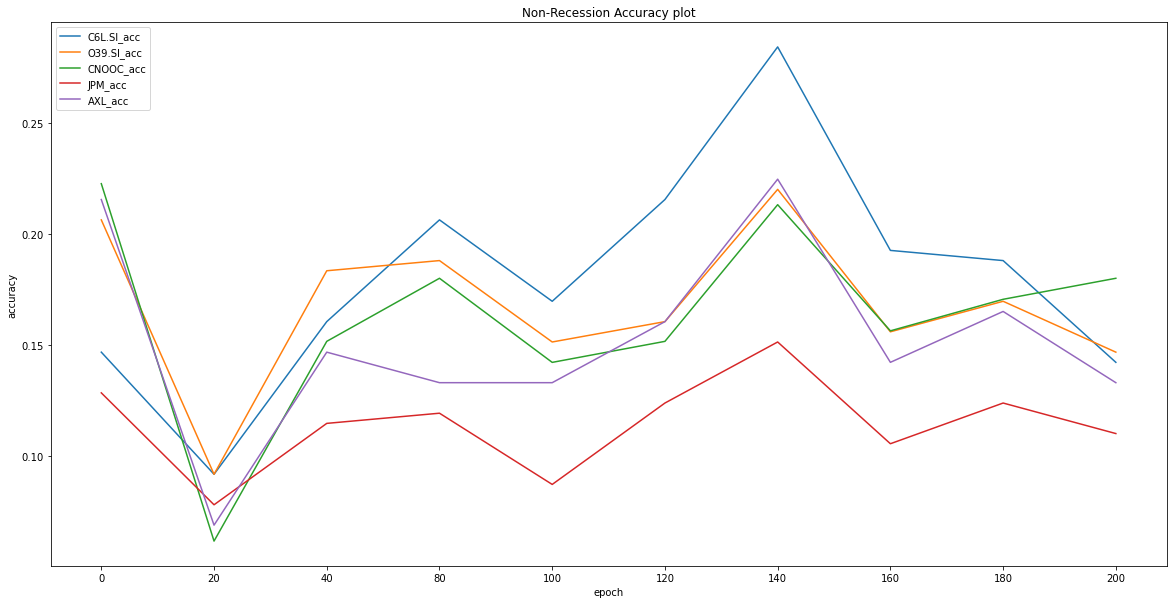

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

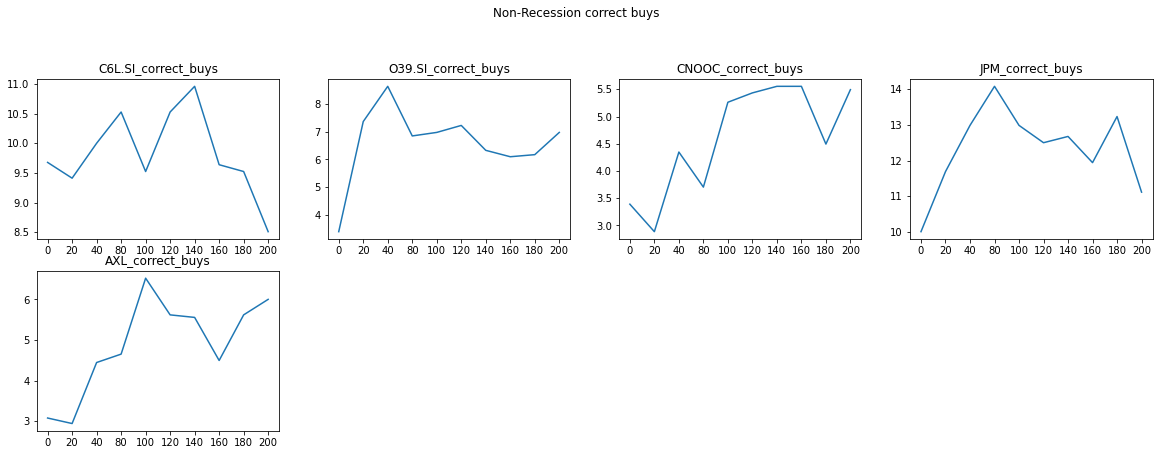

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")


Text(0.5, 1.0, 'AXL_correct_sells')

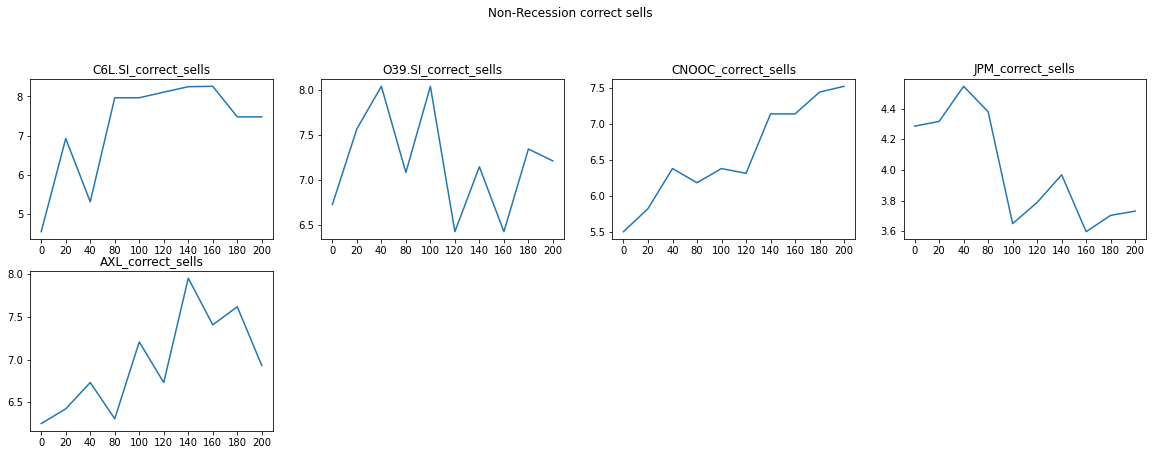

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

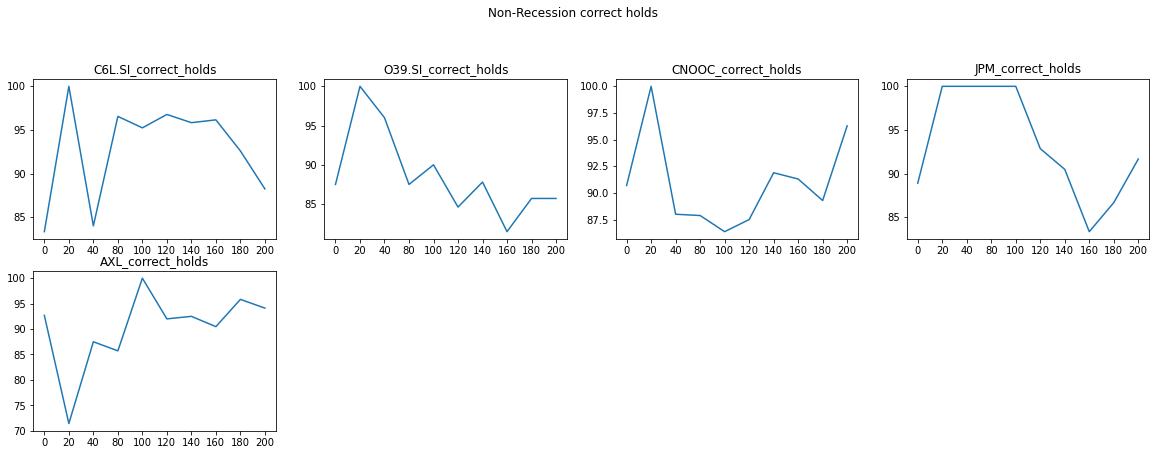

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

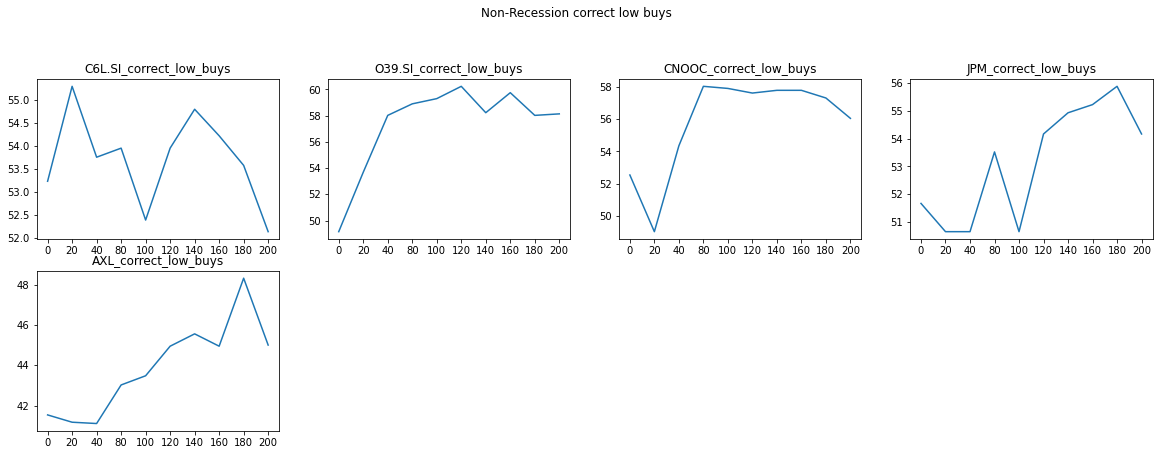

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

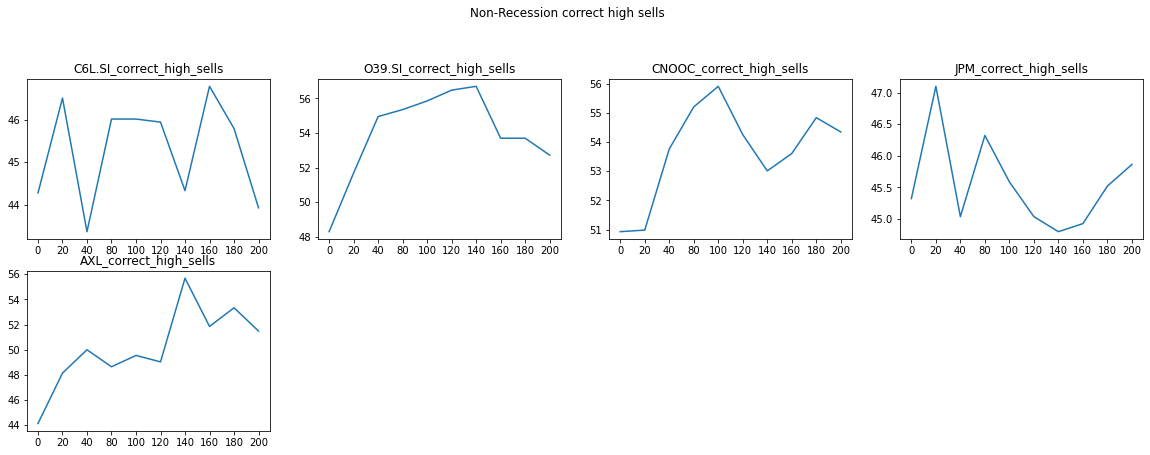

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

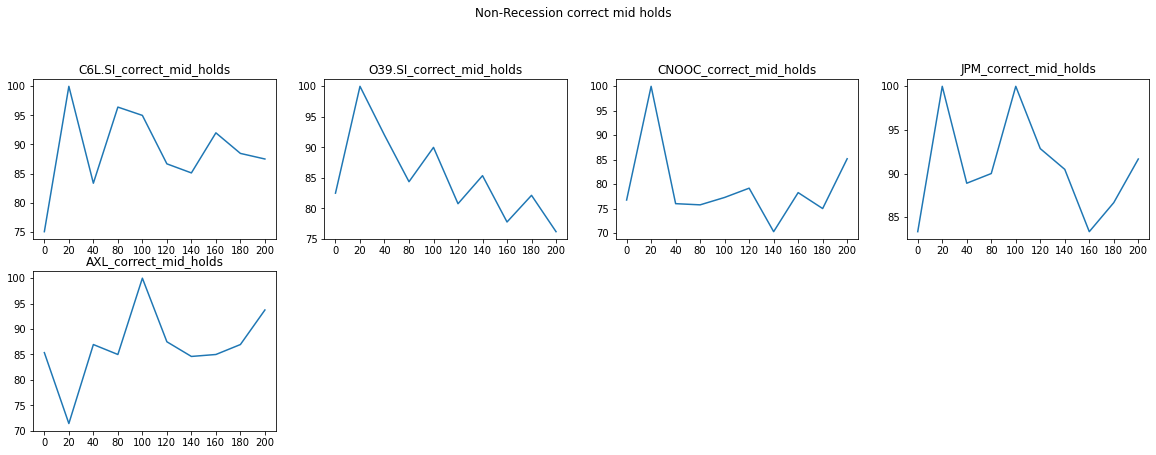

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

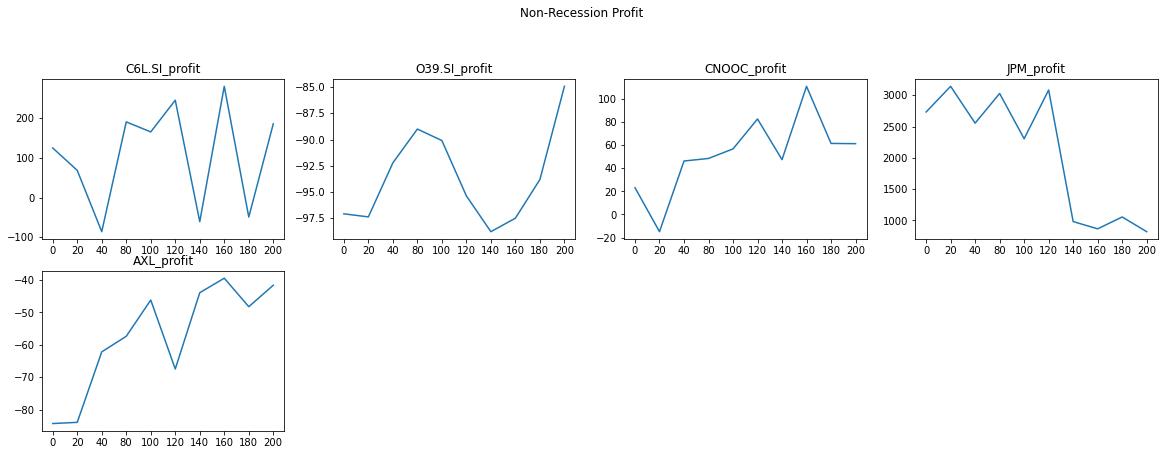

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")

In [31]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  
    

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


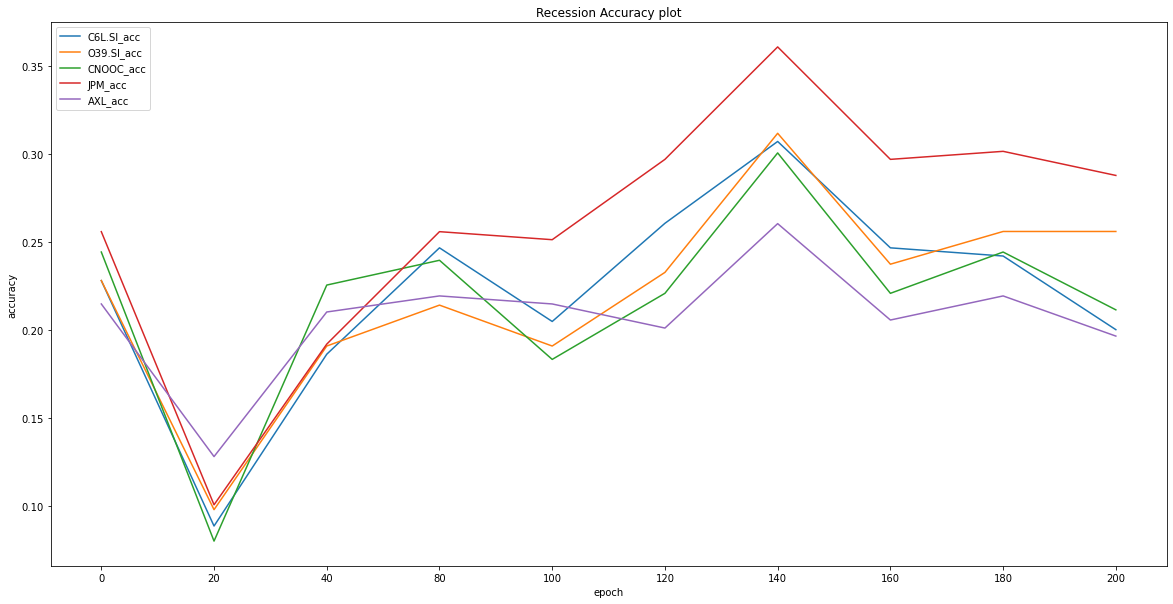

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

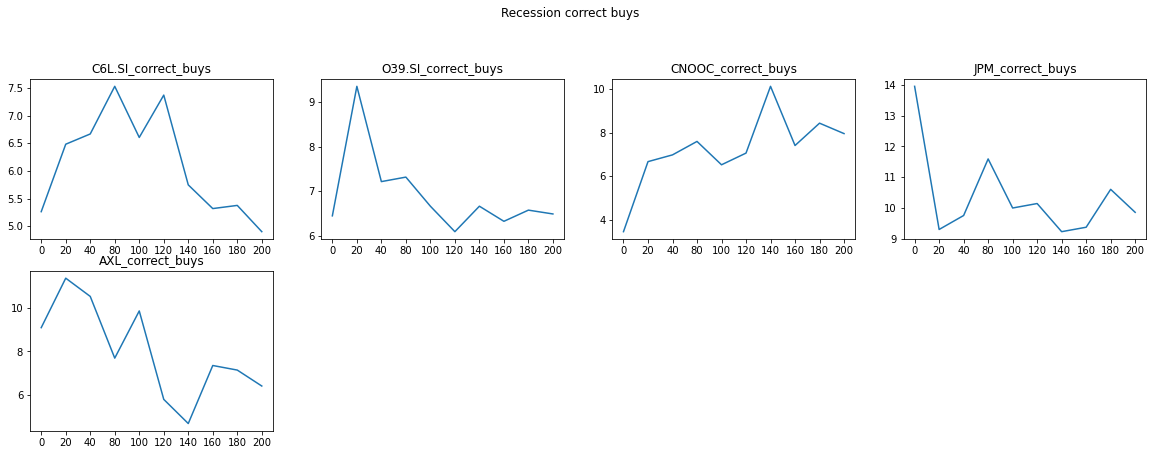

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")


Text(0.5, 1.0, 'AXL_correct_sells')

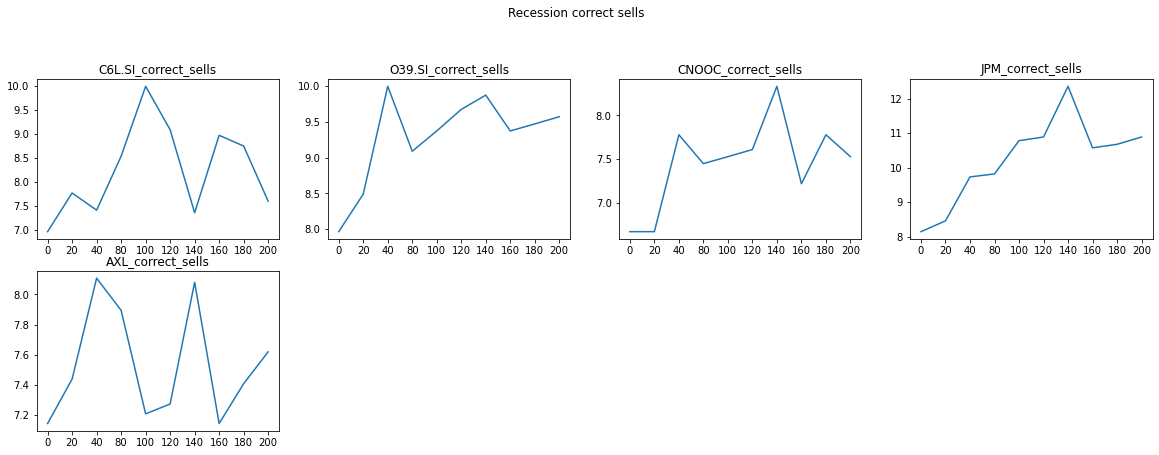

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

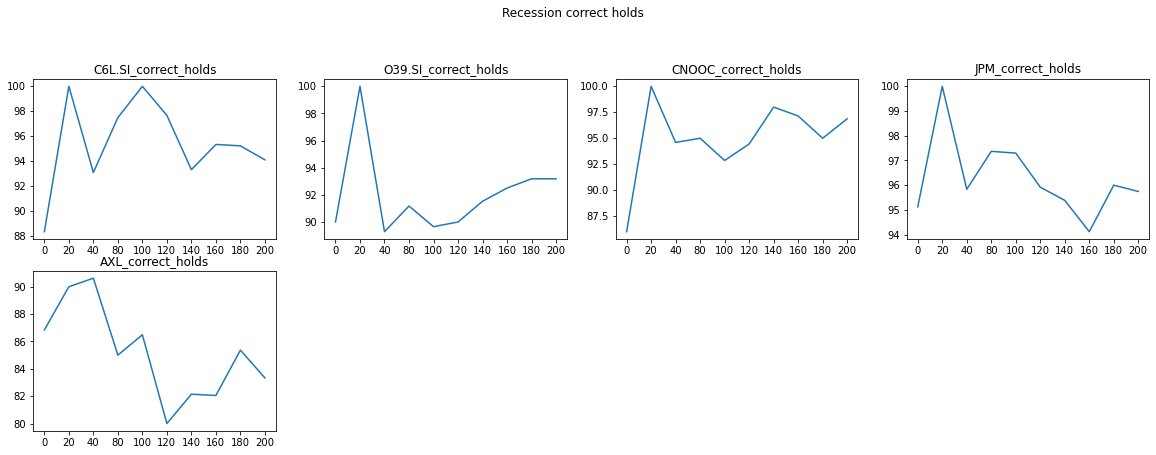

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

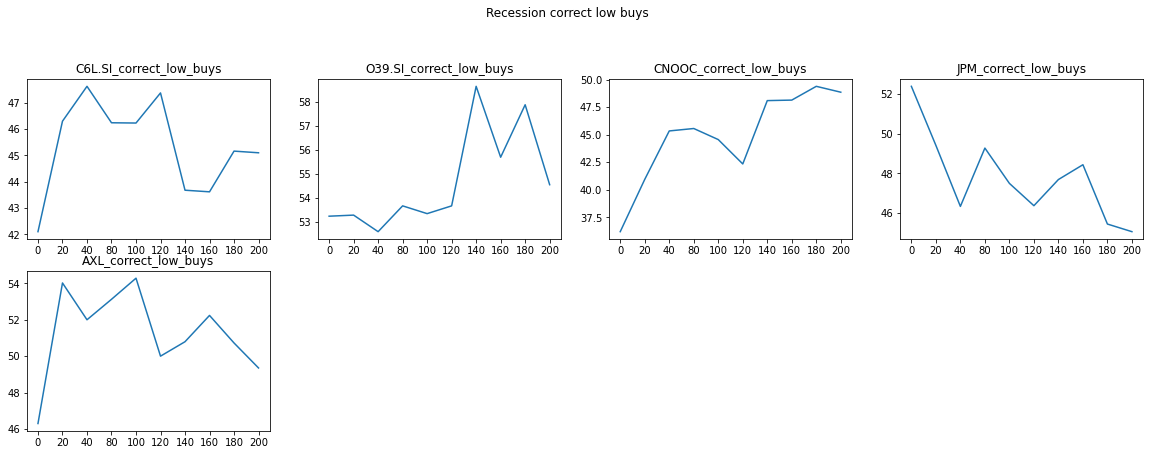

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

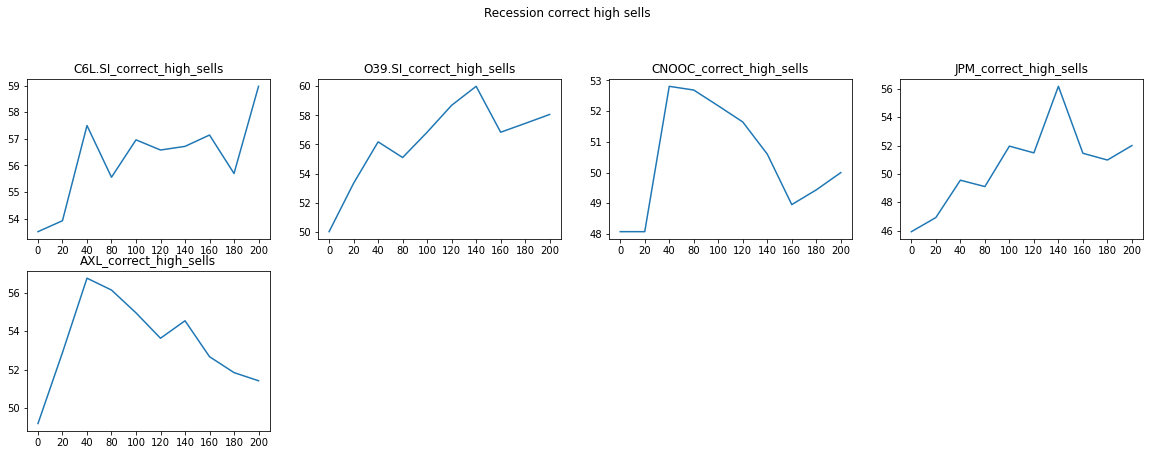

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

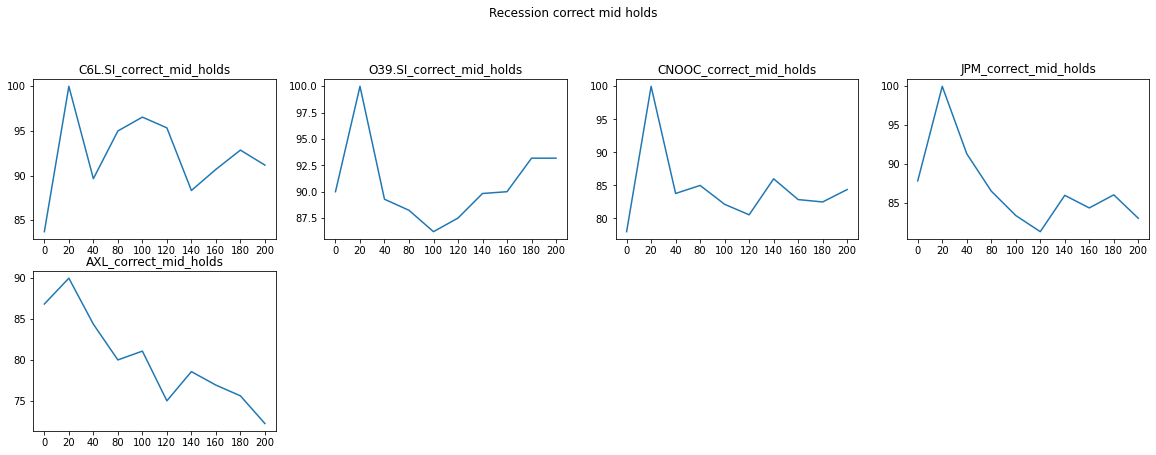

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

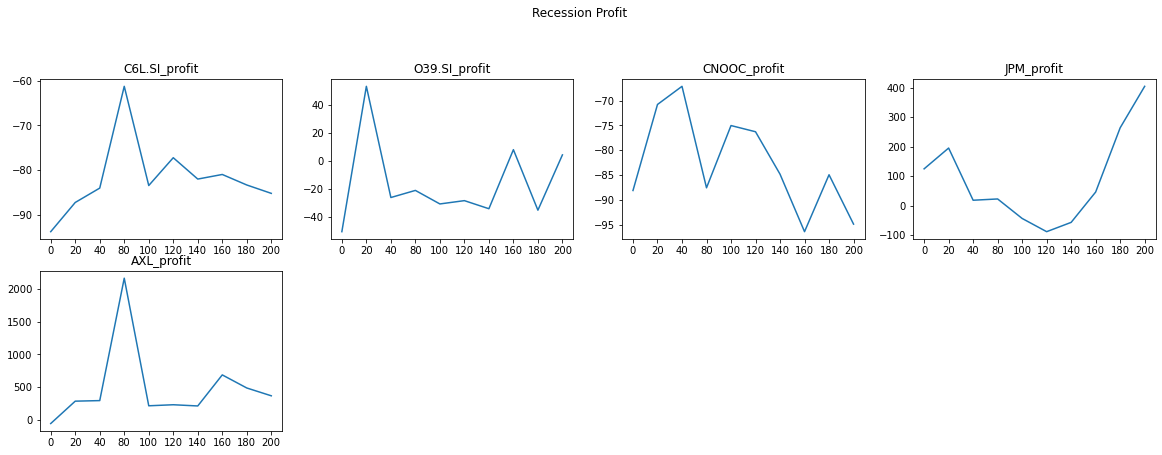

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")